# Optimization of a Voigt profile

In [1]:
from exojax.spec.lpf import voigt
import jax.numpy as jnp
import matplotlib.pyplot as plt

Let's optimize the Voigt function $V(\nu, \beta, \gamma_L)$ using exojax!
$V(\nu, \beta, \gamma_L)$ is a convolution of a Gaussian with a STD of $\beta$ and a Lorentian with a gamma parameter of $\gamma_L$. 

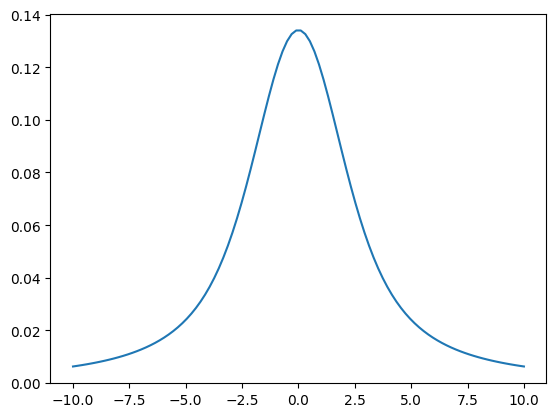

In [2]:
nu=jnp.linspace(-10,10,100)
plt.plot(nu, voigt(nu,1.0,2.0)) #beta=1.0, gamma_L=2.0

## optimization of a simple absorption model

Next, we try to fit a simple absorption model to mock data.
The absorption model is 

$ f= e^{-a V(\nu,\beta,\gamma_L)}$


In [3]:
def absmodel(nu,a,beta,gamma_L):
    return jnp.exp(-a*voigt(nu,beta,gamma_L))

Adding a noise...


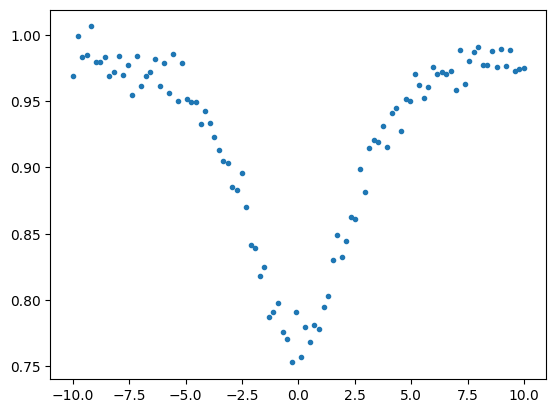

In [4]:
from numpy.random import normal
data=absmodel(nu,2.0,1.0,2.0)+normal(0.0,0.01,len(nu))
plt.plot(nu,data,".")

Let's optimize the multiple parameters

In [5]:
from jax import grad, vmap

We define the objective function as $obj = |d - f|^2$

In [6]:
# loss or objective function
def obj(a,beta,gamma_L):
    f=data-absmodel(nu,a,beta,gamma_L)
    g=jnp.dot(f,f)
    return g


In [7]:
#These are the derivative of the objective function
h_a=grad(obj,argnums=0)
h_beta=grad(obj,argnums=1)
h_gamma_L=grad(obj,argnums=2)
print(h_a(2.0,1.0,2.0),h_beta(2.0,1.0,2.0),h_gamma_L(2.0,1.0,2.0))

0.010246746 -0.00011916496 -0.0035553267


In [8]:
from jax import jit

@jit
def step(t,opt_state):
    a,beta,gamma_L=get_params(opt_state)
    value=obj(a,beta,gamma_L)
    
    grads_a = h_a(a,beta,gamma_L)
    grads_beta = h_beta(a,beta,gamma_L)
    grads_gamma_L = h_gamma_L(a,beta,gamma_L)

    grads=jnp.array([grads_a,grads_beta,grads_gamma_L])
    
    opt_state = opt_update(t, grads, opt_state)
    return value, opt_state

def doopt(r0,opt_init,get_params,Nstep):
    opt_state = opt_init(r0)
    traj=[r0]
    for t in range(Nstep):
        value, opt_state = step(t, opt_state)
        p=get_params(opt_state)
        traj.append(p)
    return traj, p

Here, we use the ADAM optimizer

In [9]:
#adam
#from jax.experimental import optimizers #for older versions of JAX
from jax.example_libraries import optimizers
opt_init, opt_update, get_params = optimizers.adam(1.e-1)
r0 = jnp.array([1.5,1.5,1.5])
trajadam, padam=doopt(r0,opt_init,get_params,1000)

Optimized values are given in padam

In [10]:
padam

Array([1.9930655 , 0.88781667, 2.0753138 ], dtype=float32)

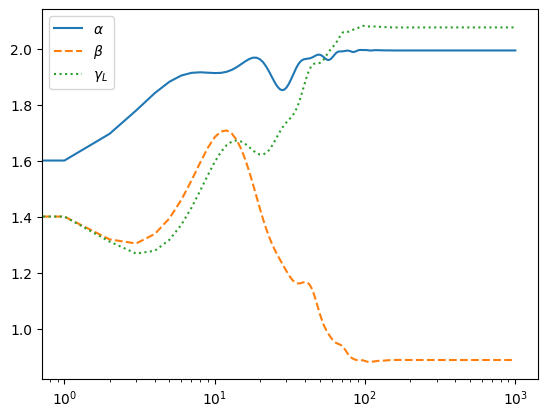

In [11]:
traj=jnp.array(trajadam)
plt.plot(traj[:,0],label="$\\alpha$")
plt.plot(traj[:,1],ls="dashed",label="$\\beta$")
plt.plot(traj[:,2],ls="dotted",label="$\\gamma_L$")
plt.xscale("log")
plt.legend()
plt.show()

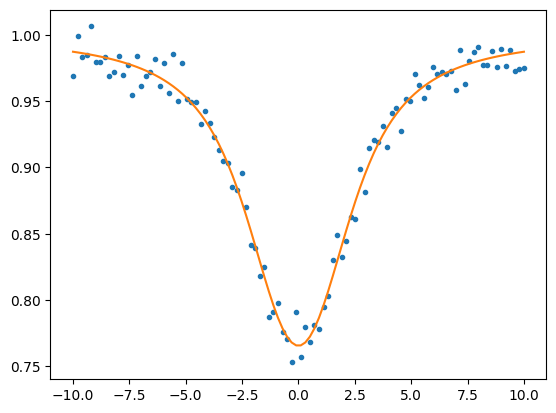

In [12]:
plt.plot(nu,data,".",label="data")
plt.plot(nu,absmodel(nu,padam[0],padam[1],padam[2]),label="optimized")
plt.show()

Using SGD instead..., you need to increase the number of iteration for convergence

In [13]:
#sgd
#from jax.experimental import optimizers #for older versions of JAX
from jax.example_libraries import optimizers

opt_init, opt_update, get_params = optimizers.sgd(1.e-1)
r0 = jnp.array([1.5,1.5,1.5])
trajsgd, psgd=doopt(r0,opt_init,get_params,10000)

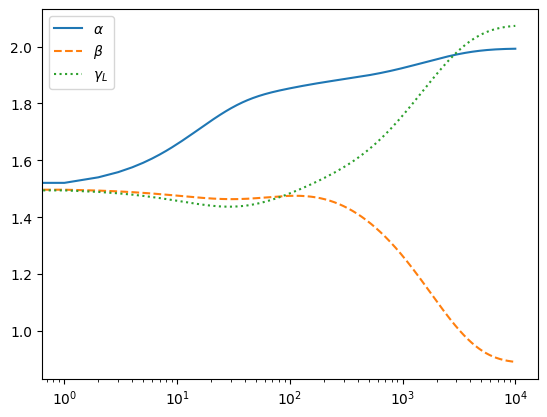

In [14]:
traj=jnp.array(trajsgd)
plt.plot(traj[:,0],label="$\\alpha$")
plt.plot(traj[:,1],ls="dashed",label="$\\beta$")
plt.plot(traj[:,2],ls="dotted",label="$\\gamma_L$")
plt.xscale("log")
plt.legend()
plt.show()